# Convolution with mask
Sometimes you need to convolve your array. Normally numpy and scipy provide excellent convolution functions. But numpy can only convolve one-dimension arrays and both of them cannot cope with NaN or Inf. Astropy has a convolution function that can interpolate over NaN values but these interpolated values are the used in the convolution. Also it cannot deal with masks (but one could just set all masked values to NaN and use astropy.convolve - if it weren't for the inclusion of these interpolated ones in the convolution.

Also a major shortcoming of all the convolution functions is that they don't offer any possibility to ignore values outside the array boundary. Astropys convolution may be able to do that but chooses not to.

Ignoring values comes at a price though. The kernel (or footprint) used in the convolution must have a sum different from zero. So any kind of kernel such as [1, -2, 1] (laplacian kernel) is not possible since it's sum is zero.

Just to get started we use a 2D image of a gaussian distribution.

In [1]:
%matplotlib inline 
from pymsastro.convolution import convolve_with_mask
import numpy as np

from astropy.convolution import convolve as astropy_convolve
from scipy.ndimage.filters import convolve as scipy_convolve
from numpy import convolve as numpy_convolve

import matplotlib.pyplot as plt
from matplotlib import pylab
pylab.rcParams['figure.figsize'] = (10.0, 5.0)

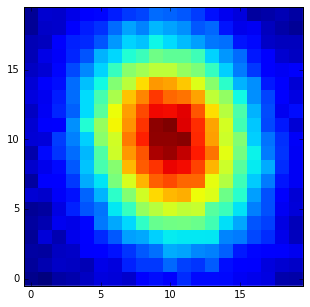

In [2]:
from astropy.modeling.functional_models import Gaussian2D
gauss = Gaussian2D(100, 10, 10, 4, 5, 60)
y, x = np.mgrid[:20, :20]
z = gauss(x,y)
z += np.random.normal(0,2,400).reshape(20,20)
plt.imshow(z, origin='lower', interpolation='None')
plt.show()

This could be easily convolved with scipy. To make things interesting suppose we have two cosmic rays that had hit the detector and left some signal there.

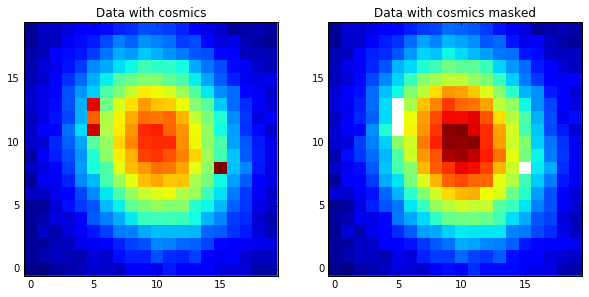

In [3]:
z_masked = np.ma.array(z, mask=False, copy=True)
z_masked.data[8,15] += 71
z_masked.mask[8,15] = True
z_masked.data[11,5] += 55
z_masked.mask[11,5] = True
z_masked.data[12,5] += 48
z_masked.mask[12,5] = True
z_masked.data[13,5] += 62
z_masked.mask[13,5] = True
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(z_masked.data, origin='lower', interpolation='None')
axarr[0].set_title('Data with cosmics')
axarr[1].imshow(z_masked, origin='lower', interpolation='None')
axarr[1].set_title('Data with cosmics masked')
plt.show()

Now we try to use scipy convolution:

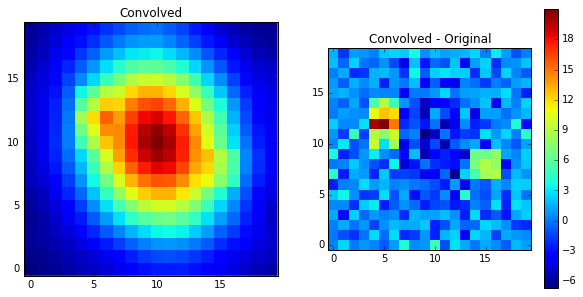

In [4]:
z_scipy = scipy_convolve(z_masked, np.ones((3,3)))
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(z_scipy, origin='lower', interpolation='None')
axarr[0].set_title('Convolved')
b = axarr[1].imshow(z_scipy/9-z, origin='lower', interpolation='None')
axarr[1].set_title('Convolved - Original')
f.colorbar(b, ax=axarr[1])
plt.show()

The area of the small cosmic ray is a little distorted but the area with the other cosmic ray got bigger. This is because scipy allows masked arrays but uses the data values nevertheless. Let's look at the difference between the convolved array and the original (without cosmic):

Now let's see what happens if we use the convolution with mask:

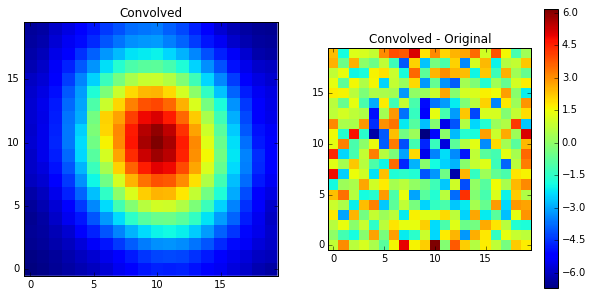

In [5]:
z_conv_mask = convolve_with_mask(z_masked, np.ones((3,3)))
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(z_conv_mask, origin='lower', interpolation='None')
axarr[0].set_title('Convolved')
b = axarr[1].imshow(z_conv_mask/9-z, origin='lower', interpolation='None')
axarr[1].set_title('Convolved - Original')
f.colorbar(b, ax=axarr[1])
plt.show()

The masked values were ignored and the image looks a lot smoother. The difference image also shows rather smaller deviations.
The boundaries where the large cosmic were seem a little lower on the left and a bit higher on the right but nothing as desastrous as with scipy convolve.

To be fair astropy convolve makes also a very good job if one sets the masked values to NaN:

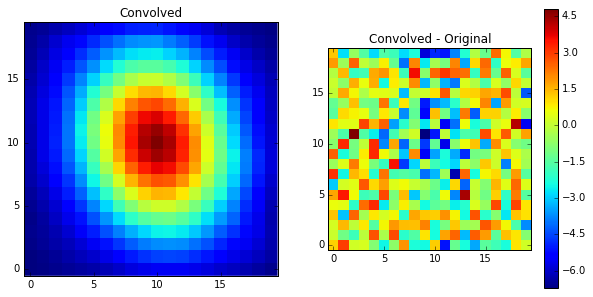

In [6]:
z_astro = np.array(z_masked.data, copy=True)
z_astro[z_masked.mask] = np.nan
z_astro = astropy_convolve(z_astro, np.ones((3,3)))
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(z_astro, origin='lower', interpolation='None')
axarr[0].set_title('Convolved')
b = axarr[1].imshow(z_astro/9-z, origin='lower', interpolation='None')
axarr[1].set_title('Convolved - Original')
f.colorbar(b, ax=axarr[1])
plt.show()

Which is almost exactly the same as the convolve with mask but requires setting masked values to NaN and is slower than convolve_with_mask. And by including the interpolated values in the convolution it makes a better job here but I rather feel that missing (or masked) values should be rather ignored than interpolated and reused.

# Benchmarking against numpy, scipy, astropy
An important fact for any convolution is speed since convolution is pretty expensive there. So I decided to compare the speed with other common convolution algorithms.

Each of these has it's own drawbacks but I'll stick to the speed here.

Let's start with a 1D array and a mean filter with box size of 3 but with increasing number of elements in the array:

In [7]:
for i in range (1,7):
    print('#'*25)
    print('{0} elements in the array'.format(10**i))
    array = np.random.normal(5, 0.5, 10**i)
    kernel = np.ones(3)
    %timeit convolve_with_mask(array, kernel)
    %timeit astropy_convolve(array, kernel)
    %timeit scipy_convolve(array, kernel)
    %timeit numpy_convolve(array, kernel, mode="same")

#########################
10 elements in the array
The slowest run took 10550.31 times longer than the fastest. This could mean that an intermediate result is being cached 
1 loops, best of 3: 67 µs per loop
10000 loops, best of 3: 155 µs per loop
10000 loops, best of 3: 89 µs per loop
The slowest run took 4.77 times longer than the fastest. This could mean that an intermediate result is being cached 
10000 loops, best of 3: 22.9 µs per loop
#########################
100 elements in the array
10000 loops, best of 3: 65.6 µs per loop
10000 loops, best of 3: 175 µs per loop
10000 loops, best of 3: 92.5 µs per loop
10000 loops, best of 3: 24 µs per loop
#########################
1000 elements in the array
10000 loops, best of 3: 112 µs per loop
1000 loops, best of 3: 327 µs per loop
10000 loops, best of 3: 121 µs per loop
10000 loops, best of 3: 31.7 µs per loop
#########################
10000 elements in the array
1000 loops, best of 3: 559 µs per loop
1000 loops, best of 3: 1.51 ms per 

For such arrays the numpy convolution performs best and the astropy convolution worst. The convolution with mask is for arrays with less elements faster than scipy but around 1000 elements scipy overtakes it.

The conclusion is numpy is better than scipy is better than mine is better than astropy.

The next thing is multidimensional arrays with multidimensional kernels (again with increasing number of array elements and this time a 3x3 1 kernel is used.

In [8]:
for i in range (1,4):
    print('#'*25)
    print('{0} x {0} elements in the array'.format(10**i))
    array = np.random.normal(5, 0.5, 10**(2*i)).reshape(10**i, 10**i)
    kernel = np.ones((3,3))
    %timeit convolve_with_mask(array, kernel)
    %timeit astropy_convolve(array, kernel)
    %timeit scipy_convolve(array, kernel)
    #%timeit numpy_convolve(array, kernel, mode="same")

#########################
10 x 10 elements in the array
10000 loops, best of 3: 85.4 µs per loop
10000 loops, best of 3: 197 µs per loop
10000 loops, best of 3: 104 µs per loop
#########################
100 x 100 elements in the array
1000 loops, best of 3: 1.89 ms per loop
100 loops, best of 3: 3.81 ms per loop
1000 loops, best of 3: 546 µs per loop
#########################
1000 x 1000 elements in the array
10 loops, best of 3: 192 ms per loop
1 loops, best of 3: 365 ms per loop
10 loops, best of 3: 47.3 ms per loop


Numpy was dismissed since it cannot process arrays with more than one dimension. But again scipy performs better than mine and far better than astropy.

But what about keeping the number of elements in the array constant but increasing the number of elements in the kernel:

In [9]:
for i in range (1,5):
    print('#'*25)
    print('{0} elements in the kernel'.format(4*i+1))
    array = np.random.normal(5, 0.5, 100000)
    kernel = np.ones(4*i+1)
    %timeit convolve_with_mask(array, kernel)
    %timeit astropy_convolve(array, kernel)
    %timeit scipy_convolve(array, kernel)
    %timeit numpy_convolve(array, kernel, mode="same")

#########################
5 elements in the kernel
100 loops, best of 3: 6.82 ms per loop
100 loops, best of 3: 16.9 ms per loop
100 loops, best of 3: 3.69 ms per loop
The slowest run took 12.06 times longer than the fastest. This could mean that an intermediate result is being cached 
1000 loops, best of 3: 1.2 ms per loop
#########################
9 elements in the kernel
100 loops, best of 3: 10.8 ms per loop
10 loops, best of 3: 25.7 ms per loop
100 loops, best of 3: 4.69 ms per loop
1000 loops, best of 3: 1.79 ms per loop
#########################
13 elements in the kernel
100 loops, best of 3: 13.8 ms per loop
10 loops, best of 3: 34.4 ms per loop
100 loops, best of 3: 5.49 ms per loop
100 loops, best of 3: 12.8 ms per loop
#########################
17 elements in the kernel
100 loops, best of 3: 17 ms per loop
10 loops, best of 3: 46.3 ms per loop
100 loops, best of 3: 8.05 ms per loop
100 loops, best of 3: 13.2 ms per loop


Here the numpy function performs best for small kernels but scipy gets faster for bigger kernels. Scipy takes only half the time of the numba-based function. Astropy performs worst.

# Conclusion

Depending on the situation one of these functions is best:

## numpy.convolve
- Pro: Very fast (if kernel is smaller than 10)
- Con: Cannot deal with arrays with more than one dimension.
- Con: Cannot deal with NaNs, mask
- Con: Offers almost no boundary options

## scipy.ndimage.convolve
- Pro: Best performance for multidimensional arrays
- Pro: Offers different boundary options
- Con: Cannot deal with NaNs, mask

## astropy.convolve
- Pro: Can deal with NaN
- Pro: Offers different boundary options
- Con: Slow

## convolve_with_mask
- Pro: Performance better than astropy
- Pro: Deals with masks
- Con: 2xslower than scipy for 100k elements, 4xslower than scipy for 1kk elements
- Con: Offers no boundary options